# Getting started


In this notebook, we show how to use pepme to evaluate sequences and adding your own metric.


First the imports.


In [ ]:
import pickle
from pprint import pprint
from typing import Literal

import numpy as np
import pandas as pd

from pepme import (
    FeatureCache,
    barplot,
    combine_metric_dataframes,
    compute_metrics,
    show_table,
)
from pepme.core import Metric, MetricResult
from pepme.metrics import FBD, ID, Novelty, Precision, Recall, Uniqueness
from pepme.models.properties import Gravy
from pepme.utils import random_subset, read_fasta_file, write_to_fasta_file

## Basics


Let's define the sequences to use and the metrics to compute. Some sequences will be loaded from fasta files, others are hard-coded.


First let's write a fasta file with random sequences to disk.


In [ ]:
RANDOM_SEQUENCES_PATH = "./data/random.fasta"

In [ ]:
random_sequences = ["KKKKK", "PLQ", "RKSPL"]

write_to_fasta_file(random_sequences, RANDOM_SEQUENCES_PATH)

UniProt contains a lot of sequences. To speed-up the metric computations, we will only use a (random) subset of the UniProt sequences.


In [ ]:
sequences = {
    "Random": read_fasta_file(RANDOM_SEQUENCES_PATH),
    "UniProt": random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
    "HydrAMP": ["MMRK", "RKSPL", "RRLSK", "RRLSK"],
    "hyformer": ["MKQW", "RKSPL"],
}


# @TODO: replace with PhysicoChemicalEmbedder when implemented
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T

Metrics may precompute some values upon metric object creation to speed up the overall process.


In [ ]:
metrics = [
    Uniqueness(),
    Novelty(reference=sequences["UniProt"], reference_name="UniProt"),
    FBD(reference=sequences["Random"], embedder=my_embedder),
    ID(Gravy(), name="Gravy", objective="minimize"),
]

Let's compute the metrics.


In [ ]:
df = compute_metrics(sequences, metrics)

 38%|███▊      | 6/16 [00:00<00:00, 1153.87it/s, data=UniProt, metric=FBD]              /Users/rasmus.larsen/work/hackathon-2025/pepme/src/pepme/metrics/fbd.py:101: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, err = sqrtm(sigma1.dot(sigma2), disp=False)
 94%|█████████▍| 15/16 [00:00<00:00, 1388.38it/s, data=hyformer, metric=Gravy]            

100%|██████████| 16/16 [00:00<00:00, 1428.58it/s, data=hyformer, metric=Gravy]


Let's look at the results.


In [ ]:
df

Uniqueness           Novelty (UniProt)                 FBD            \
              value deviation             value deviation     value deviation   
Random         1.00       NaN               1.0       NaN  0.000000       NaN   
UniProt        1.00       NaN               0.0       NaN  3.961130       NaN   
HydrAMP        0.75       NaN               1.0       NaN  8.602244       NaN   
hyformer       1.00       NaN               1.0       NaN  8.228118       NaN   

             Gravy            
             value deviation  
Random   -1.911111  1.460678  
UniProt  -2.400000  0.650000  
HydrAMP  -1.627500  0.363413  
hyformer -1.500000  0.100000

... let's make it nicer to look at.


In [ ]:
show_table(df, decimals=2)

,Uniqueness↑,Novelty (UniProt)↑,FBD↓,Gravy↓
Random,1.00,1.00,0.00,-1.91±1.46
UniProt,1.00,0.00,3.96,-2.40±0.65
HydrAMP,0.75,1.00,8.60,-1.63±0.36
hyformer,1.00,1.00,8.23,-1.50±0.10


We are particularly interested in the following metric.


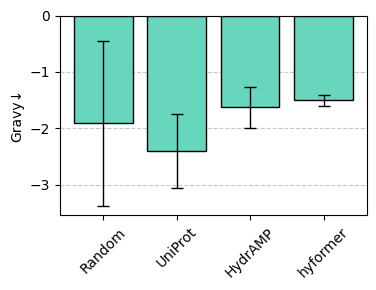

In [ ]:
barplot(df, "Gravy")

To write a metric dataframe to disk, encode the dataframe as a pickle object.


In [ ]:
PATH = "./metrics_dataframe.pkl"

df.to_pickle(PATH)
show_table(pd.read_pickle(PATH))

,Uniqueness↑,Novelty (UniProt)↑,FBD↓,Gravy↓
Random,1.00,1.00,0.00,-1.91±1.46
UniProt,1.00,0.00,3.96,-2.40±0.65
HydrAMP,0.75,1.00,8.60,-1.63±0.36
hyformer,1.00,1.00,8.23,-1.50±0.10


That it all for the basic usage of pepme. Let's look at some more advanced features!


## Advanced


In the advanced section, we show how to

- Combine multiple metric dataframes into one.
- Improve performance through caching.
- Create your own metric.


### Combining metric dataframes

pepme's `combine_metric_dataframes` can combine metric dataframes with different sequences and/or metrics. This can be useful if you want to evaluate the sequences on an additional metric or add an additional set of sequences for evaluation - without needing to recompute the results.


Let's create three metric dataframes.


In [ ]:
df1 = compute_metrics(
    sequences={
        "s1": ["KKKKK", "PLUQ", "RKSPL"],
        "s2": random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
        "s3": ["MMRK", "RKSPL", "RRLSK"],
        "s4": ["MKQW", "RKSPL"],
    },
    metrics=[
        Novelty(reference=["KKW", "RKSPL"]),
        Novelty(reference=["RASD", "KKKQ", "LPTUY"], reference_name="Random"),
    ],
    verbose=False,
)

df2 = compute_metrics(
    sequences={"s4": ["MKQW", "RKSPL"], "s5": ["MKQW"]},
    metrics=[ID(Gravy(), name="Gravy", objective="minimize")],
    verbose=False,
)

df3 = compute_metrics(
    sequences={"s6": ["MKQW", "RKSPL"]},
    metrics=[
        ID(Gravy(), name="Gravy", objective="minimize"),
        Novelty(reference=["KKW", "RKSPL"]),
    ],
    verbose=False,
)

Let's combine the dataframes.


In [ ]:
df = combine_metric_dataframes([df1, df2, df3])

In [ ]:
df

Novelty           Novelty (Random)           Gravy          
       value deviation            value deviation value deviation
s1  0.666667       NaN              1.0       NaN   NaN       NaN
s2  1.000000       NaN              0.5       NaN   NaN       NaN
s3  0.666667       NaN              1.0       NaN   NaN       NaN
s4  0.500000       NaN              1.0       NaN  -1.5       0.1
s5       NaN       NaN              NaN       NaN  -1.6       0.0
s6  0.500000       NaN              NaN       NaN  -1.5       0.1

... let's make it nicer to look at.


In [ ]:
show_table(df, decimals=[3, 2, 1], color="#d66868")

,Novelty↑,Novelty (Random)↑,Gravy↓
s1,0.667,1.00,-
s2,1.000,0.50,-
s3,0.667,1.00,-
s4,0.500,1.00,-1.5±0.1
s5,-,-,-1.6±0.0
s6,0.500,-,-1.5±0.1


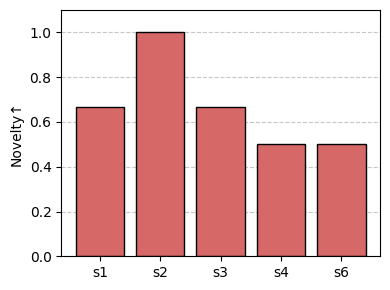

In [ ]:
barplot(df, "Novelty", color="#d66868", ylim=(0.0, 1.1), x_ticks_label_rotation=0.0)

Notice missing values (e.g., "Novelty" for "s5") are not shown in the barplot.


### Caching

Discriminators and embedders can be computational expensive to execute. To reduce the number of function evaluations for these models, we can cache the results of discriminators and embedders.

The cache works like this: If a (sequence, embedding)-pair is already stored in the cache then retrieve the embedding. Otherwise compute the embedding, store the pair in the cache and retrieve the embedding.

Let's create two toy models and the cache.


In [ ]:
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


def my_discriminator(sequences: list[str]) -> np.ndarray:
    return np.ones(len(sequences)) * 0.85


cache = FeatureCache(
    models={"embedder": my_embedder, "discriminator": my_discriminator},
)

Optional: We can manually add model outputs to the cache. This is useful when e.g., (sequence, embedding)-pairs are already pre-computed and stored in a file.


In [ ]:
seqs = ["MKQW", "AA", "BB"]
reps = my_embedder(seqs)

pairs = dict(zip(seqs, reps, strict=True))

cache.add_to_cache(model_name="embedder", pairs=pairs)

Let's compute the metrics. Since both the `Precision` and `Recall` metric use the same embedding model (`embedder`), the embedding is only computed once per sequence in `sequences` (instead of twice)!

Notice, we now use `cache.model()` instead of the embedder reference (`my_embedder`) directly.


In [ ]:
df = compute_metrics(
    sequences={
        "hyformer": ["RMKQW", "RKSPL", "RRRASD"],
        "HydrAMP": ["MKQW", "RKSPLP"],
        "Random": ["AAA", "PPPPP"],
    },
    metrics=[
        Precision(
            reference=["AKWR", "AKKR", "KKKK"],
            embedder=cache.model("embedder"),
            neighborhood_size=1,
            strict=False,
        ),
        Recall(
            reference=["AKWR", "AKKR", "KKKK"],
            embedder=cache.model("embedder"),
            neighborhood_size=1,
            strict=False,
        ),
    ],
)

show_table(df, color="#69bce8")

100%|██████████| 6/6 [00:00<00:00, 363.13it/s, data=Random, metric=Recall]    


,Precision↑,Recall↑
hyformer,0.67,0.00
HydrAMP,0.50,0.67
Random,0.00,0.33


Let's write the cached (sequence, embedding)-pairs for each model to a file and reinitialize the cache.


In [ ]:
PATH = "precomputed.pkl"

with open(PATH, "wb") as f:
    pickle.dump(cache.get_cache(), f)

with open(PATH, "rb") as f:
    precomputed = pickle.load(f)

cache = FeatureCache(init_cache=precomputed)
pprint(cache.get_cache())

{'discriminator': {},
 'embedder': {'AA': array([2, 0]),
              'AAA': array([3, 0]),
              'AKKR': array([4, 2]),
              'AKWR': array([4, 1]),
              'BB': array([2, 0]),
              'KKKK': array([4, 4]),
              'MKQW': array([4, 1]),
              'PPPPP': array([5, 0]),
              'RKSPL': array([5, 1]),
              'RKSPLP': array([6, 1]),
              'RMKQW': array([5, 1]),
              'RRRASD': array([6, 0])}}


### Creating a new metric


You can also integrate your own metrics into pepme through the `Metric` interface as shown below.


In [ ]:
class MyMetric(Metric):
    def __init__(self, amino_acid: str, minimize: bool = True):
        self.amino_acid = amino_acid
        self.minimize = minimize

    def __call__(self, sequences: list[str]) -> MetricResult:
        aa_count = sum([seq.count(self.amino_acid) for seq in sequences])
        aa_total = sum([len(sequence) for sequence in sequences])
        return MetricResult(aa_count / aa_total)

    @property
    def name(self) -> str:
        return f"{self.amino_acid}-frequency"

    @property
    def objective(self) -> Literal["minimize", "maximize"]:
        return "minimize" if self.minimize else "maximize"

Let's use our new metric.


In [ ]:
df = compute_metrics(
    sequences={
        "hyformer": ["MKQW", "RKSPL", "RASD"],
        "HydrAMP": ["MKQW", "RKSPL"],
        "Random": ["AAAA", "PPPPP"],
    },
    metrics=[
        MyMetric(amino_acid="K", minimize=False),
        MyMetric(amino_acid="R", minimize=True),
    ],
)

show_table(df, color="#e07fe1")

100%|██████████| 6/6 [00:00<00:00, 6727.03it/s, data=Random, metric=R-frequency]  


,K-frequency↑,R-frequency↓
hyformer,0.15,0.15
HydrAMP,0.22,0.11
Random,0.00,0.00


This is all there is to pepme! 🎉
